# SWW Reconstruction Algorithm Simulation
## Michael Hétu
## Fall 2023

This program serves to develop and test the Synthetic Wideband Waveform reconstruction algorithm for use in Stepped Frequency Continuous Wave Ground Penetrating Radar

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.signal.windows as windows
from scipy.fft import fft, fftshift, ifft, ifftshift, fftfreq

### Defining important parameters and variables

In [2]:
c = 3e8 #Speed of light

Bi = 9e6 # Chirp bandwidth
fs = 18e6 # Sample rate
N = 2**20 #Number of samples, power of 2
Tp = N/fs # Chirp duration 

samp_shift = 250000 #Delay time, max resolved delay is Tp/2
time_delay = samp_shift *(1/fs)
print("Number of samples:", N)
print("Delay time:", time_delay, "s. Sample shift:", samp_shift)
print("Length of a full chirp:", Tp)

K = Bi/(Tp) # Linear chirp frequency rate

t = np.linspace(0, Tp, N) # Time point vector for digitized waveform

Number of samples: 1048576
Delay time: 0.013888888888888888 s. Sample shift: 250000
Length of a full chirp: 0.05825422222222222


### Creating waveforms

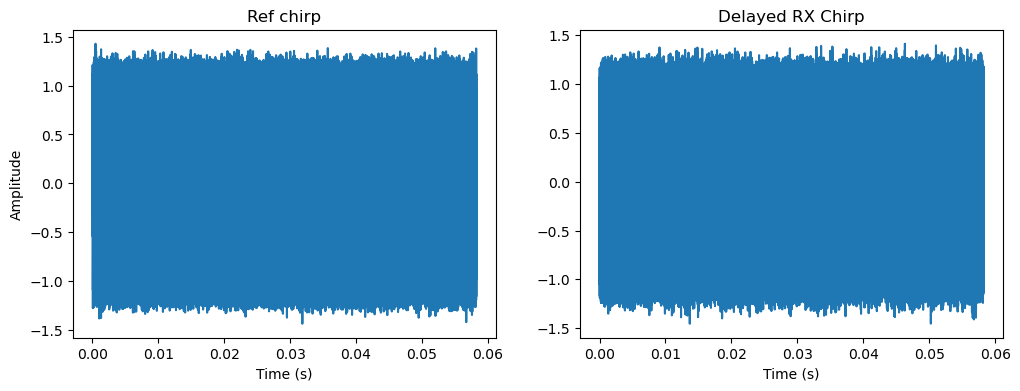

In [3]:
# Initializing reference waveform
def chirp(t, K):
    #return np.array(np.exp(1j*np.pi*K*t**2))
    return np.sin(np.pi * K * t**2)

# Initializing reference waveform
ref_chirp = chirp(t, K) + np.random.normal(0,0.1,N)

# Initializing reflected waveform (echo)
R = 206 # Distance to surface causing reflection
rx_chirp = (np.roll(ref_chirp, -samp_shift) + np.roll(ref_chirp, -int(samp_shift/2)))/2 + np.random.normal(0,0.1,N)

#Plotting

f, ax = plt.subplots(1,2, figsize = (12,4), sharey = False)

ax[0].plot(t, ref_chirp.real)
ax[1].plot(t, rx_chirp.real)

ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Time (s)")

ax[0].set_ylabel("Amplitude")

ax[0].set_title("Ref chirp")
ax[1].set_title("Delayed RX Chirp")

plt.show()

### Performing FFTs on the chirps

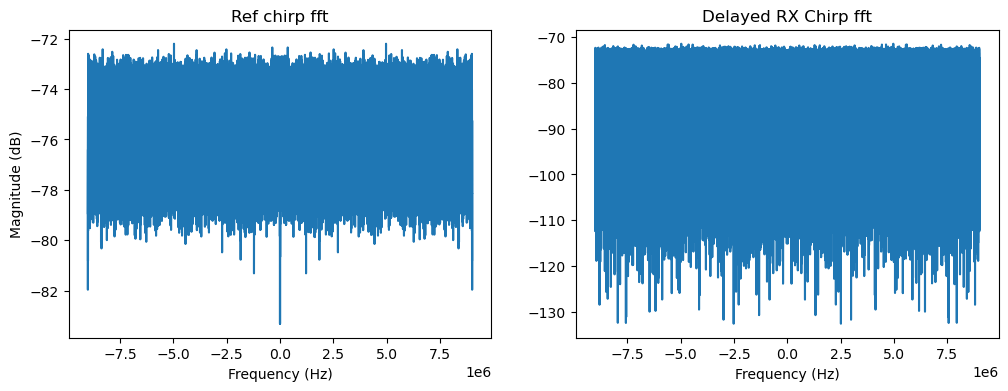

In [4]:
W = windows.boxcar(int(N)) # FFT window 

ref_chirp*W

# FFTs and FFTshift to center at 0Hz
ref_dft = fftshift(fft(ref_chirp*W))
rx_dft = fftshift(fft(rx_chirp*W))

freqs = fftshift(fftfreq(N, 1/fs)) #Frequency range

#Plotting the FFT Power Spectrum
f, ax = plt.subplots(1,2, figsize = (12,4), sharey = False)

mag_ref = 10*np.log10(np.abs(ref_dft)**2/(N*fs))
mag_rx = 10*np.log10(np.abs(rx_dft)**2/(N*fs))

ax[0].plot(freqs, mag_ref)
ax[1].plot(freqs, mag_rx)

ax[0].set_xlabel("Frequency (Hz)")
ax[1].set_xlabel("Frequency (Hz)")

ax[0].set_ylabel("Magnitude (dB)")

ax[0].set_title("Ref chirp fft")
ax[1].set_title("Delayed RX Chirp fft")

plt.show()

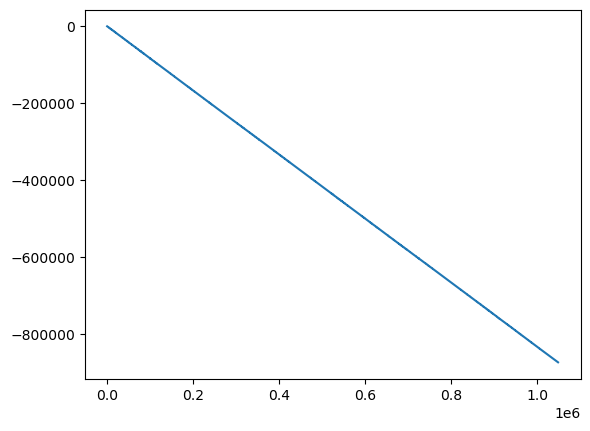

In [5]:
phase = np.angle(ref_dft * np.conj(rx_dft))
plt.plot(np.unwrap(phase))

### Computing the matched filter output

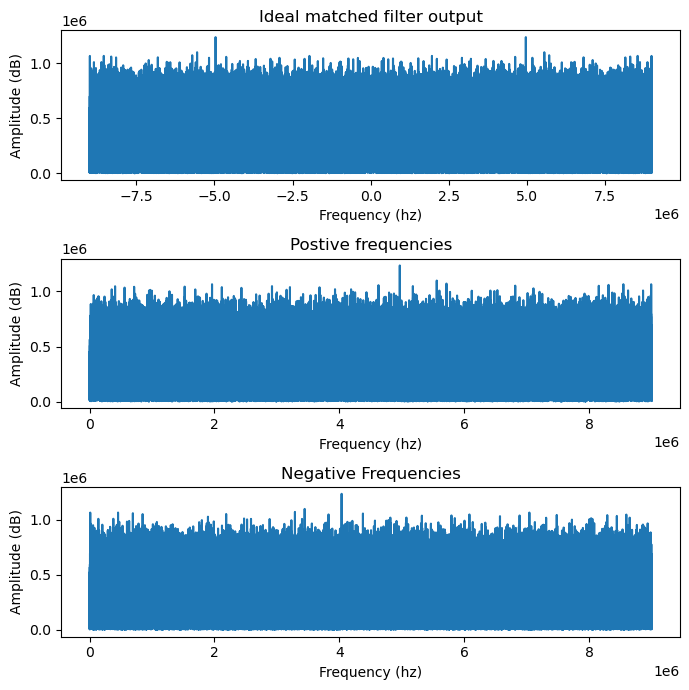

In [6]:
#Matched Filter
mf_dft = ref_dft * np.conjugate(rx_dft)

#Used for plotting positive and negative frequencies
N2 = int(N/2)
freqs2 = freqs[int(len(freqs)/2):]

#Plotting the matched filter output
f, ax = plt.subplots(3,1, figsize = (7,7))

ax[0].plot(freqs, np.abs(mf_dft))
ax[1].plot(freqs2, np.abs(mf_dft[N2:]))
ax[2].plot(freqs2, np.abs(mf_dft[:N2]))

ax[0].set_xlabel("Frequency (hz)")
ax[1].set_xlabel("Frequency (hz)")
ax[2].set_xlabel("Frequency (hz)")

ax[0].set_ylabel("Amplitude (dB)")
ax[1].set_ylabel("Amplitude (dB)")
ax[2].set_ylabel("Amplitude (dB)")

ax[0].set_title("Ideal matched filter output")
ax[1].set_title("Postive frequencies")
ax[2].set_title("Negative Frequencies")

plt.tight_layout()
plt.show()

### IFFT on the matched filter

/home/mhetu/miniconda3/envs/env1/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mhetu/miniconda3/envs/env1/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


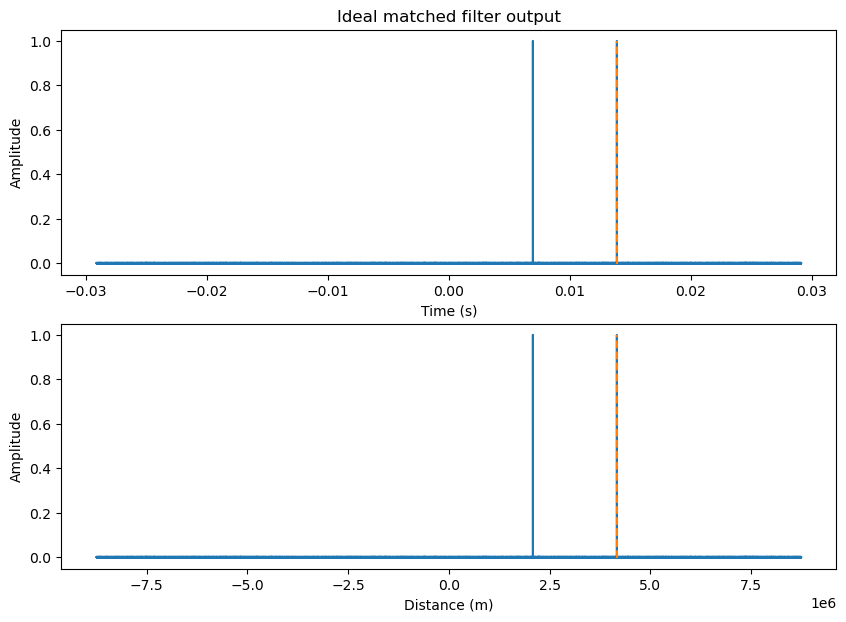

In [7]:
mf_idft = ifftshift(ifft(mf_dft))
mf_idft /= np.max(mf_idft)

t_out = np.linspace(-Tp/2, Tp/2, int(N))
dist = t_out * c

f, ax = plt.subplots(2,1, figsize = (10,7))

ax[0].plot(t_out, mf_idft)
ax[0].plot(np.full(10, time_delay), np.linspace(min(mf_idft), max(mf_idft), 10), linestyle = "--")
ax[1].plot(dist, mf_idft)
ax[1].plot(np.full(10, time_delay*c), np.linspace(min(mf_idft), max(mf_idft), 10), linestyle = "--")


ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Distance (m)")

ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")

ax[0].set_title("Ideal matched filter output")

plt.show()

### Stacking Algorithm

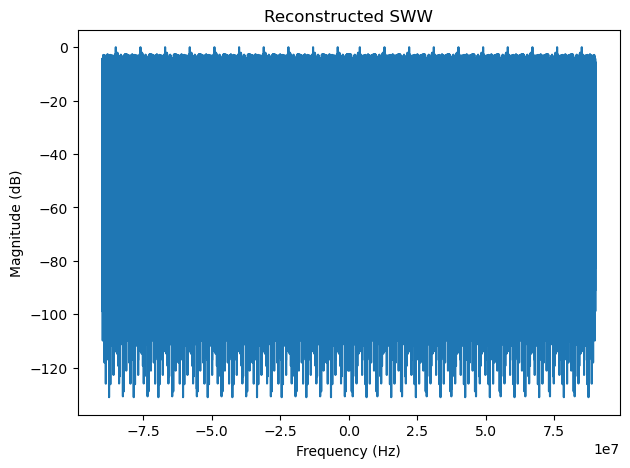

In [8]:
nsp = 10 # Number of sub pulses
Bft = Bi*nsp # Set reconstucted bandwidth here

delf = Bi #the frequency step between broadband pulses

Nf = int(len(mf_dft)*nsp/2)
dft_stack = np.zeros(Nf*2, dtype = np.complex128)

for i in range(nsp):
    
    #Seperate matched filter into real and imaginary components
    dft_real = mf_dft[:N2]
    dft_imag = mf_dft[N2:]
    
    #Sufficiently pad each side
    dft_real_pad = np.pad(dft_real, (Nf, Nf-N2), mode = 'constant', constant_values = (0,0))
    dft_imag_pad = np.pad(dft_imag, (Nf-N2, Nf), mode = 'constant', constant_values = (0,0))
    
    #Perform a circular shift corresponding to the frequency spacing between broadband pulses
    dft_real_shift = np.roll(dft_real_pad, int(i*len(mf_dft)/2))
    dft_imag_shift = np.roll(dft_imag_pad, -int(i*len(mf_dft)/2))
    
    #Add to the stack array and repeat
    dft_stack += dft_real_shift
    dft_stack += dft_imag_shift

mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)

N2 = int(N/2)
freqs_stack = np.linspace(-Bi*nsp, Bi*nsp, num=len(mag_stack))

f, ax = plt.subplots(figsize = (7,5))

ax.plot(freqs_stack, mag_stack)

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude (dB)")

ax.set_title("Reconstructed SWW")

plt.show()

In [9]:
dft_stack.shape

(10485760,)

ValueError: num must be an integer with 1 <= num <= 2, not 3

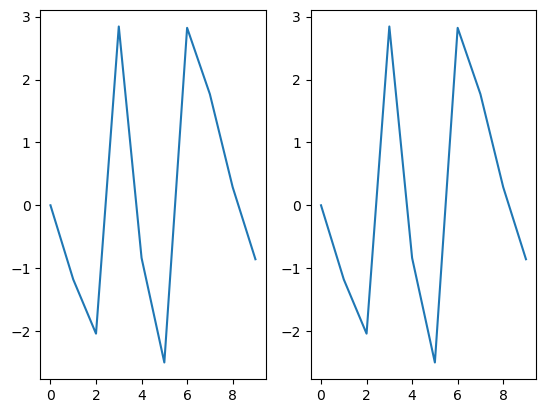

In [10]:
phase = np.angle(dft_stack)
# unphase = np.unwrap(phase)
plt.subplot(121)
plt.plot(phase[0:10])

plt.subplot(122)
plt.plot(phase[N:N+10])

plt.subplot(123)
plt.plot(phase[2*N-10:2*N])

### IFFT on the SWW signal

In [11]:
sww = ifftshift(ifft(dft_stack)) #Ifft

sww = 20*np.log10(sww/N2)

#New time and distance vectors, note an increase in resolution prop to nsp
t_out = np.linspace(-Tp/2, Tp/2, N*nsp)
dist = t_out * c

f, ax = plt.subplots(2,1, figsize = (10,7))

ax[0].plot(t_out, sww)
ax[0].plot(np.full(10, time_delay), np.linspace(min(sww), max(sww), 10), linestyle = "--")
ax[1].plot(dist, sww)
ax[1].plot(np.full(10, time_delay*c), np.linspace(min(sww), max(sww), 10), linestyle = "--")


ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Distance (m)")

ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")

ax[0].set_title("Ideal matched filter output")

plt.show()

/tmp/ipykernel_88601/1471281216.py:3: RuntimeWarning: divide by zero encountered in log10
  sww = 20*np.log10(sww/N2)
/tmp/ipykernel_88601/1471281216.py:3: RuntimeWarning: invalid value encountered in multiply
  sww = 20*np.log10(sww/N2)


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 1000x700 with 2 Axes>

### Visual demonstration of the stacking algorithm, if needed.
These plots are not well labeled

In [ ]:
nsp = 5 # Number of sub pulses
Bft = Bi*nsp # Set reconstucted bandwidth here

delf = Bi #the frequency step between broadband pulses

Nf = int(len(mf_dft)*nsp/2)
dft_stack = np.zeros(Nf*2, dtype = np.complex128)

for i in range(nsp):
    
    print('This is stack number', i, 'of', nsp)
    
    dft_real = mf_dft[:N2]
    dft_imag = mf_dft[N2:]
    
    f, ax = plt.subplots(1,2, figsize = (10,4))
    ax[0].plot(np.abs(dft_imag))
    ax[1].plot(np.abs(dft_real))
    ax[0].set_title("imag")
    ax[1].set_title('real')
    plt.suptitle("Positive and Negative frequencies")
    plt.show()
    
    dft_real_pad = np.pad(dft_real, (Nf, Nf-N2), mode = 'constant', constant_values = (0,0))
    dft_imag_pad = np.pad(dft_imag, (Nf-N2, Nf), mode = 'constant', constant_values = (0,0))
    
    f, ax = plt.subplots(1,2, figsize = (10,4))
    ax[0].plot(np.abs(dft_imag_pad))
    ax[1].plot(np.abs(dft_real_pad))
    ax[0].set_title("imag")
    ax[1].set_title('real')
    plt.suptitle("Padded")
    plt.show()
    
    dft_real_shift = np.roll(dft_real_pad, int(i*len(mf_dft)/2))
    dft_imag_shift = np.roll(dft_imag_pad, -int(i*len(mf_dft)/2))
    
    f, ax = plt.subplots(1,2, figsize = (10,4))
    ax[0].plot(np.abs(dft_imag_shift))
    ax[1].plot(np.abs(dft_real_shift))
    ax[0].set_title("imag")
    ax[1].set_title('real')
    plt.suptitle("Shifted")
    plt.show()
    
    dft_stack += dft_real_shift
    dft_stack += dft_imag_shift
    
    plt.plot(np.abs(dft_stack))
    plt.title("Stacked")
    plt.show()
    